In [27]:
import os
import glob
import imghdr
import cv2

import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, AveragePooling2D, ReLU, LeakyReLU, Softmax

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn

%config Completer.use_jedi = False

In [43]:
data_generator = ImageDataGenerator(rescale=1./255)
test1_data = data_generator.flow_from_directory('images_v2_for_data_augmentation\\test',
                           target_size=(256, 256),
                           batch_size=16,
                           shuffle=False,
                          class_mode='sparse')

Found 1616 images belonging to 3 classes.


In [108]:
test2_data = data_generator.flow_from_directory('test_images_v2',
                           target_size=(256, 256),
                           batch_size=16,
                           shuffle=False,
                          class_mode='sparse')

Found 60 images belonging to 3 classes.


In [30]:
from fnmatch import fnmatch
def load_models(directory):
    model_paths, models = [], []
    for path, subdirs, files in os.walk(directory):
        for name in files:
            if fnmatch(name, "*.h5"):
                model_path = os.path.join(path, name)
                print(model_path)
                model_paths.append(model_path)
                model = tf.keras.models.load_model(model_path, compile=False)
                model.compile()
                models.append(model)
    return model_paths, models

In [31]:
model_paths, models = [], []
for directory in ["ensemble_training"]:
    model_paths_temp, models_temp = load_models('saved_models/' + directory)
    model_paths.extend(model_paths_temp)
    models.extend(models_temp)

saved_models/ensemble_training\animal_recogniser\v2-2023-2-10-13-25-17.h5
saved_models/ensemble_training\car_recogniser\base-2023-2-10-13-42-46.h5
saved_models/ensemble_training\human_recogniser\v2-2023-2-10-14-27-56.h5


In [97]:
def evaluate(data):
    y_pred_a = models[0].predict(x=data, steps=len(data), verbose=0)
    y_pred_c = models[1].predict(x=data, steps=len(data), verbose=0)
    y_pred_h = models[2].predict(x=data, steps=len(data), verbose=0)

    yhats = []
    for i in range(0, len(y_pred_a)):
        yhats_temp = []
        yhats_temp.append(y_pred_a[i][0])
        yhats_temp.append(y_pred_c[i][0])
        yhats_temp.append(y_pred_h[i][0])           
        yhats.append(yhats_temp.index(max(yhats_temp)))
    accuracy = accuracy_score(data.classes, yhats)
    
    return accuracy, yhats

In [106]:
def get_cm(data, accuracy, yhats):
    cm = confusion_matrix(data.classes, yhats)

    dataframe_cm = pd.DataFrame(cm, index = [label for label in ["animal", "car", "human"]],
                      columns = [label for label in ["animal", "car", "human"]])
    plt.figure(figsize = (4,4))
    plt.figtext(0.25, -0.02, f"Accuracy: {round(accuracy, ndigits=3)}", fontsize=14)
    ax = plt.axes()
    cm = sn.heatmap(dataframe_cm, annot=True, fmt='g', ax=ax)
    ax.set_title("Ensemble models")
    plt.show()

In [100]:
accuracy_test1, yhats_test1 = evaluate(test1_data)

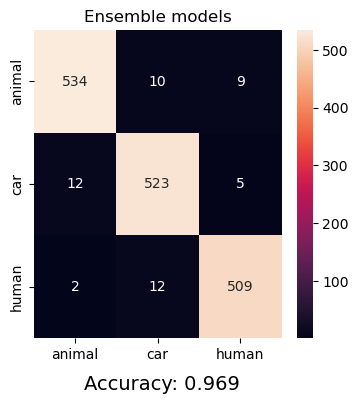

In [107]:
get_cm(test1_data, accuracy_test1, yhats_test1)

In [109]:
accuracy_test2, yhats_test2 = evaluate(test2_data)

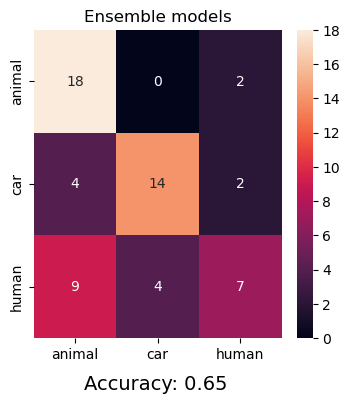

In [110]:
get_cm(test2_data, accuracy_test2, yhats_test2)